# FITS Image Handling in Astropy


## Summary

This tutorial demonstrates the use of `astropy.utils.data` to download a data file, then uses `astropy.io.fits` to open the file, and lastly uses `matplotlib` to view the image with different color scales and stretches and to make histograms. In this tutorial we've also included a demonstration of simple image stacking.

## Acknoweldgement

This module is 'inspired' by the tutorial on FITS Handling by the Astropy project. 

## FITS File

[FITS](https://en.wikipedia.org/wiki/FITS) stands for Flexible Image Transport System and is the most commonly used file format for astronomical data. Read through [this](https://photographingspace.com/how-to-use-fits/) article to know more about the format and its necessity. 

<p align="centre">
<img src="assets/img1.png" width="500">
</p>

<p align="centre">
<img src="assets/img2.png" width="500">
</p>

There are softwares such as [SAOImage DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9) which allow you to open FITS files natively on your pc but we will be using Python in this module. To download files on your own you can visit [STScI Archive](https://archive.stsci.edu/cgi-bin/dss_form) and search by name or coordinates to locate any object of your choice. 

In [1]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

Download the example FITS files for this tutorial.

In [2]:
from astropy.utils.data import download_file
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

## Opening FITS files and loading the image data

Let's open the FITS file to find out what it contains.

In [3]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: /home/b_anshuman/.astropy/cache/download/url/ff6e0b93871033c68022ca026a956d87/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Generally, the image information is located in the <code>PRIMARY</code> block. The blocks are numbered and can be accessed by indexing <code>hdu_list</code>.

In [4]:
image_data = hdu_list[0].data

Our data is now stored as a 2D numpy array.  But how do we know the dimensions of the image?  We can look at the `shape` of the array.

In [5]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


Great! At this point, we can close the FITS file because we've stored everything we wanted to a variable.

In [6]:
hdu_list.close()

### SHORTCUT

If you don't need to examine the FITS header, you can call `fits.getdata` to bypass the previous steps.

In [7]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


## Viewing the image data and getting basic statistics

In [13]:
arr = np.array([[1,4,234,32,35,63,213,32],
       [0,0,255,255,200,90,200,0],
       [40,254,23,64,56,100,200,0]])

In [15]:
arr.reshape((6,4))

array([[  1,   4, 234,  32],
       [ 35,  63, 213,  32],
       [  0,   0, 255, 255],
       [200,  90, 200,   0],
       [ 40, 254,  23,  64],
       [ 56, 100, 200,   0]])

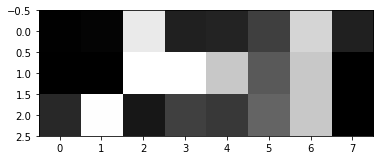

In [17]:
plt.imshow(arr, cmap='gray')

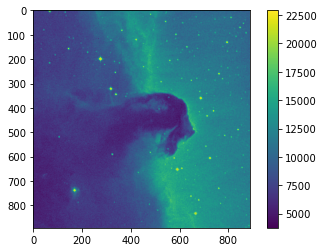

In [8]:
plt.imshow(image_data, cmap='viridis')
plt.colorbar()
# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

Let's get some basic statistics about our image:

In [18]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 3759
Max: 22918
Mean: 9831.481676287574
Stdev: 3032.3927542049046


### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, we'll need to cast the data from a 2D array to something one dimensional. In this case, let's use the `ndarray.flatten()` to return a 1D numpy array.

In [19]:
print(type(image_data.flatten()))

<class 'numpy.ndarray'>


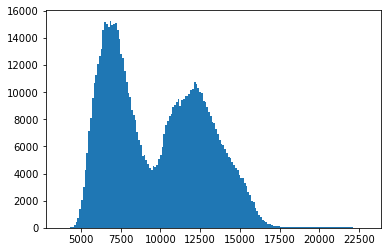

In [20]:
histogram = plt.hist(image_data.flatten(), bins='auto')

### Displaying the image with a logarithmic scale

What if we want to use a logarithmic color scale? To do so, we'll need to load the `LogNorm` object from `matplotlib`.

In [12]:
from matplotlib.colors import LogNorm

[Text(1, 0, '5,000'), Text(1, 0, '10,000'), Text(1, 0, '20,000')]

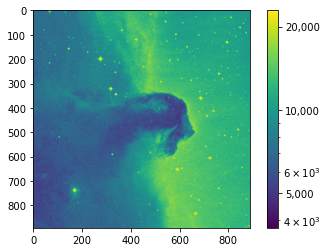

In [13]:
plt.imshow(image_data, cmap='viridis', norm=LogNorm())

# I chose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

## Basic Image Math: Image Stacking

You can also perform math with the image data like any other numpy array.  In this particular example, we'll stack several images of M13 taken with a ~10'' telescope.

[Image stacking](https://en.wikipedia.org/wiki/Focus_stacking) is often performed to reduce noise in an image and increase its [Depth of Field](https://en.wikipedia.org/wiki/Depth_of_field). In actual processing we often take a series of Bias images and Flats to further enhance the quality of an image. However we will not be covering them in this module due to time constraints. 

Let's start by opening a series of FITS files and store the data in a list, which we've named `image_concat`.

In [21]:
base_url = 'http://data.astropy.org/tutorials/FITS-images/M13_blue_{0:04d}.fits'

image_list = [download_file(base_url.format(n), cache=True) 
              for n in range(1, 5+1)]
image_concat = [fits.getdata(image) for image in image_list]

Let us now display the first image and look at its features. You should be able to see a faint blob of stars near the center of the frame. 

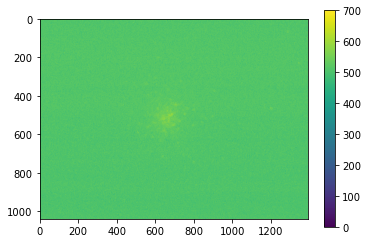

In [22]:
plt.imshow(image_concat[0], cmap='viridis')
plt.colorbar()

Now we'll stack the images by summing the concatenated list.

In [23]:
# The long way
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image

# The short way
# final_image = np.sum(image_concat, axis=0)

We're going to show the image, but need to decide on the best stretch. To do so let's plot a histogram of the data.

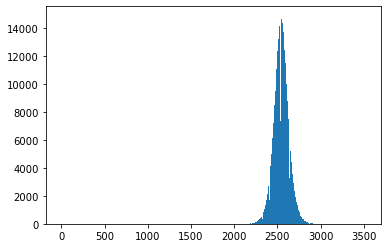

In [24]:
image_hist = plt.hist(final_image.flatten(), bins='auto')

We'll use the keywords `vmin` and `vmax` to set limits on the color scaling for `imshow`.

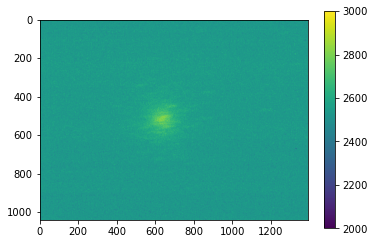

In [25]:
plt.imshow(final_image, cmap='viridis', vmin=2E3, vmax=3E3)
plt.colorbar()

You can clearly see that after stacking the quality of the image has been enhanced. 

## Writing image data to a FITS file

We can do this with the `writeto()` method.

Warning: you'll receive an error if the file you are trying to write already exists.  That's why we've set `overwrite=True`.

In [26]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, overwrite=True)

## Exercise

Download your own FITS images from the site mentioned above and try playing with 'vmin' and 'vmax' and different scalings such as Log, Power etc. 